# Sleep Health Predictor 

### Notebook on Data Cleaning, Preparation and Modeling 


### Goal: 
Predict **Quality of sleep** based on an individual's Gender, Age, Occupation, Sleep Duration, Stress Level, Heart Rate



### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### Read the data
The data has been downloaded from Kaggle [*Sleep Health and Lifestyle Dataset*](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset)

To download this data into your local machine, run the script [kaggle-data-import](https://github.com/eadka/sleep-health-predictor/blob/main/data/kaggle-data-import.ipynb) 

In [3]:
df = pd.read_csv('../data/sleep_health_lifestyle.csv')

In [4]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


### Data Preparation and Feature Engineering
Lets prepare the data for further evaluation

##### Step 1: Make all the column names small letters and replaces spaces with '_'

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['person_id', 'gender', 'age', 'occupation', 'sleep_duration',
       'quality_of_sleep', 'physical_activity_level', 'stress_level',
       'bmi_category', 'blood_pressure', 'heart_rate', 'daily_steps',
       'sleep_disorder'],
      dtype='object')

##### Step 2: Lets look at the data to find missing values and other metrics

In [6]:
df.describe()

,person_id,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


##### Some observations:
- **Age**: The age group of individuals in the dataset is between 27-59 years.
- **Sleep Duration**: Range is between 5.8-8.5 hours.
- **Quality of sleep**: This is a subjective rating of the quality of sleep, ranging from 1 to 10. Range: 4-9.
- **Physical Activity Level**: The number of minutes the person engages in physical activity daily. Range: 30-90 mins (Everyone exercises!)
- **Stress Level**: A subjective rating of the stress level experienced by the person, ranging from 1 to 10. Range: 3-8.
- **Heart Rate**: The resting heart rate of the person in beats per minute. Range: 65-86 bpm.
- **Daily Steps**: The number of steps the person takes per day. Range: 3000-10000

Let's clean the missing values

In [123]:
df.isnull().sum()

gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
heart_rate                 0
daily_steps                0
sleep_disorder             0
systolic                   0
diastolic                  0
dtype: int64

In [124]:
df['sleep_disorder'] = df['sleep_disorder'].fillna('None')

In [125]:
df.isnull().sum()

gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
heart_rate                 0
daily_steps                0
sleep_disorder             0
systolic                   0
diastolic                  0
dtype: int64

##### Step 3: Feature Engineering on the numeric columns from the categorical ones

In [7]:
df.dtypes

person_id                    int64
gender                      object
age                          int64
occupation                  object
sleep_duration             float64
quality_of_sleep             int64
physical_activity_level      int64
stress_level                 int64
bmi_category                object
blood_pressure              object
heart_rate                   int64
daily_steps                  int64
sleep_disorder              object
dtype: object

Let's separate the numeric and categorical columns

In [8]:
numerical = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64')]
numerical

Index(['person_id', 'age', 'sleep_duration', 'quality_of_sleep',
       'physical_activity_level', 'stress_level', 'heart_rate', 'daily_steps'],
      dtype='object')

In [9]:
categorical = df.columns[(df.dtypes == 'object')]
categorical

Index(['gender', 'occupation', 'bmi_category', 'blood_pressure',
       'sleep_disorder'],
      dtype='object')

Lets understand the distribution of labels in the **categorical columns**

In [10]:
for c in categorical:
    print(df[c].value_counts())
    print()

gender
Male      189
Female    185
Name: count, dtype: int64

occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Scientist                4
Software Engineer        4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

bmi_category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

blood_pressure
130/85    99
140/95    65
125/80    65
120/80    45
115/75    32
135/90    27
140/90     4
125/82     4
128/85     3
132/87     3
117/76     2
130/86     2
126/83     2
119/77     2
135/88     2
128/84     2
131/86     2
139/91     2
115/78     2
129/84     2
142/92     2
118/75     2
118/76     1
122/80     1
121/79     1
Name: count, dtype: int64

sleep_disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64



From the above categorical variables, the `blood_pressure` would be better used if it were a numeric variable. Lets separate the text into two values - the higher as `systolic` and the lower as `diastolic` and convert them into integers.

In [11]:
bp_split = df['blood_pressure'].str.split('/', expand=True)

In [12]:
df['systolic'] = bp_split[0].astype(int)
df['diastolic'] = bp_split[1].astype(int)

Lets now get rid of the `blood_pressure` column from the dataset and rearrange our **numerical** and **categorical** variables

In [13]:
del df['blood_pressure']

Let's also delete the `person_id` column because it's not a useful feature

In [14]:
del df['person_id']

We can also see that the `bmi_category` has redundant tags: *Normal* and *Normal Weight*.
Lets merge these as *Normal*

In [15]:
df.loc[df['bmi_category'] == 'Normal Weight', 'bmi_category'] = 'Normal'

In [16]:
df['bmi_category'].value_counts()

bmi_category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64

In [17]:
df.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


Let's remove `quality_of_sleep` from the numeric columns because that is our *target variable*

In [22]:
numerical = numerical.difference(['quality_of_sleep'])
numerical

Index(['age', 'daily_steps', 'diastolic', 'heart_rate',
       'physical_activity_level', 'sleep_duration', 'stress_level',
       'systolic'],
      dtype='object')

### Exploratory Data Analysis

Lets look at the distribution of all the features by plotting them

First, we'll look at the numeric columns

In [23]:
df_num = df[numerical]

Let's plot them all

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'daily_steps'}>,
        <Axes: title={'center': 'diastolic'}>],
       [<Axes: title={'center': 'heart_rate'}>,
        <Axes: title={'center': 'physical_activity_level'}>,
        <Axes: title={'center': 'sleep_duration'}>],
       [<Axes: title={'center': 'stress_level'}>,
        <Axes: title={'center': 'systolic'}>, <Axes: >]], dtype=object)

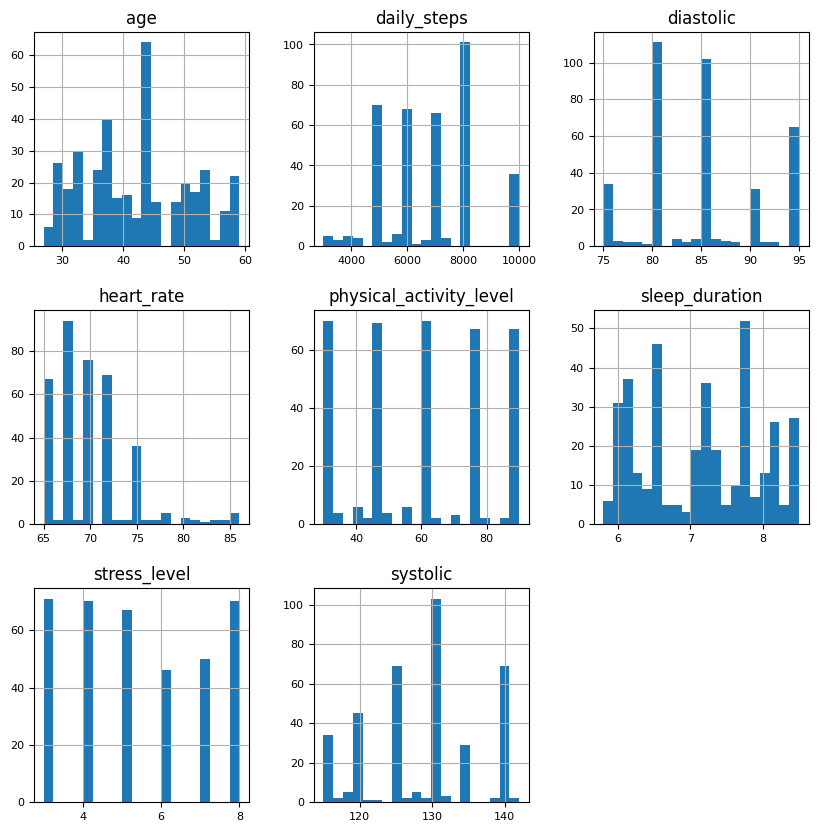

In [24]:
df_num.hist(figsize=(10,10), bins=20, xlabelsize=8, ylabelsize=8)

Lets now try the Feature to Feature relationship

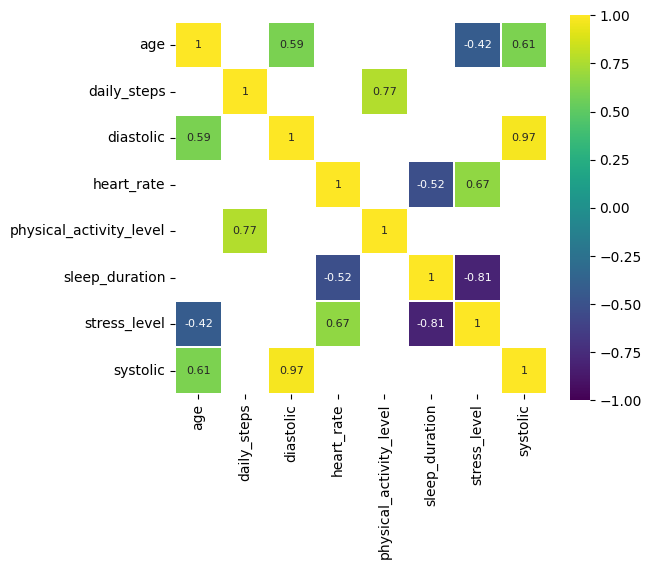

In [25]:
corr = df_num.corr()
plt.figure(figsize=(6,5))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Observations**
- `sleep_duration` and `quality_of_sleep` are positively correlated which means the longer one sleeps, the better the quality of sleep? We'll need to explore this further..
- `sleep_duration` and `quality_of_sleep` are negatively correlated with `stress_level`, which is expected
- `age` is positively correlated with systolic and diastolic, which means as we age the BP increases?
- `stress_level` and `heart_rate` are positively correlated

Lets now plot the numerical features against `quality_of_sleep` to see how they are correlated

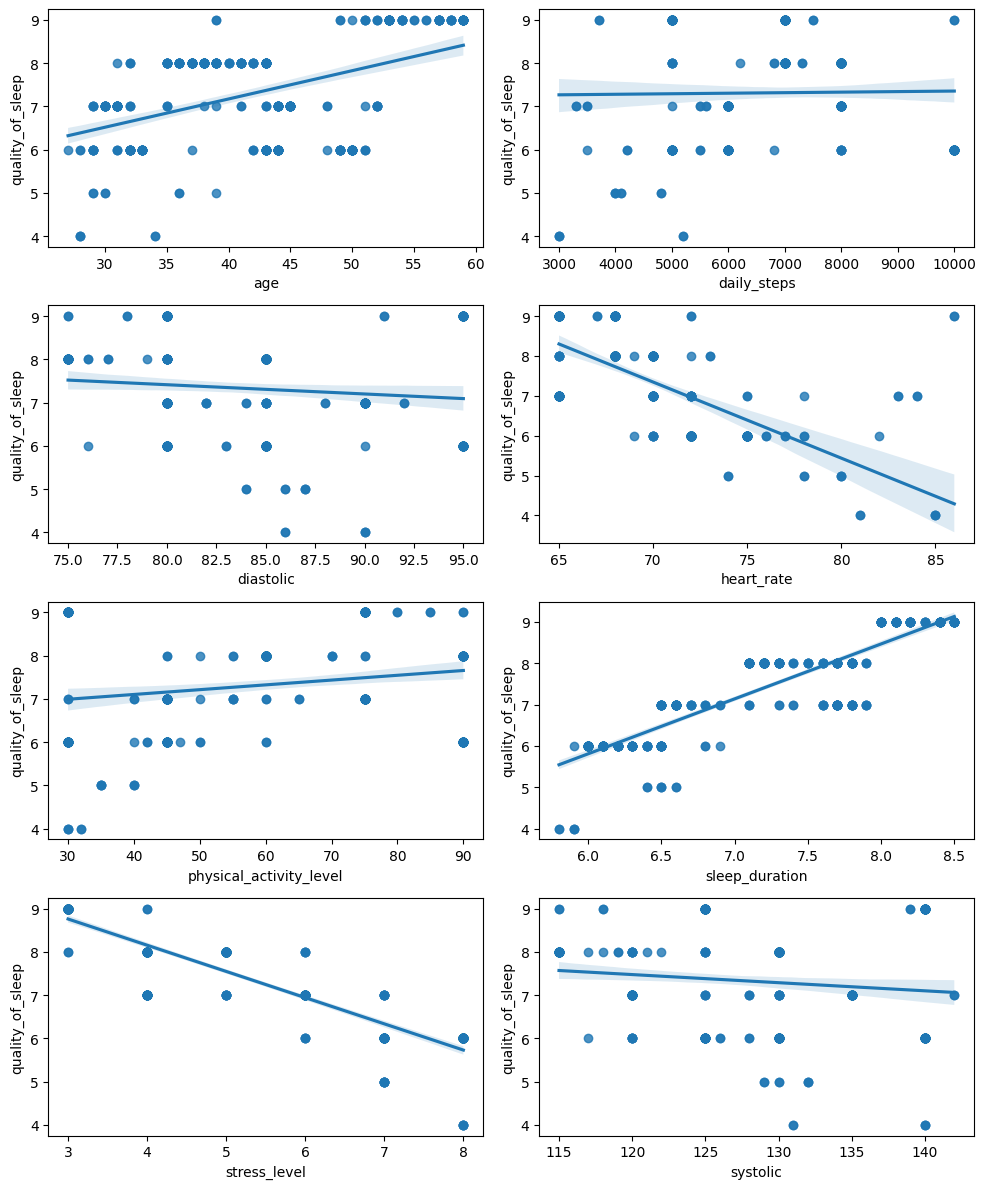

In [137]:
fig, ax = plt.subplots(round(len(numerical)/2), 2, figsize = (10,12))

for i, ax in enumerate(fig.axes):
    if i < len(numerical):
        sns.regplot(x=numerical[i], y='quality_of_sleep', data=df, ax=ax)
fig.tight_layout()

**Observations**

From the above, looks like `quality_of_sleep` is: 
- positively correlated with `age` and `sleep_duration`
- negatively correlated with `stress_level` and `heart_rate`

Now let's evaluate how the categorical variables look

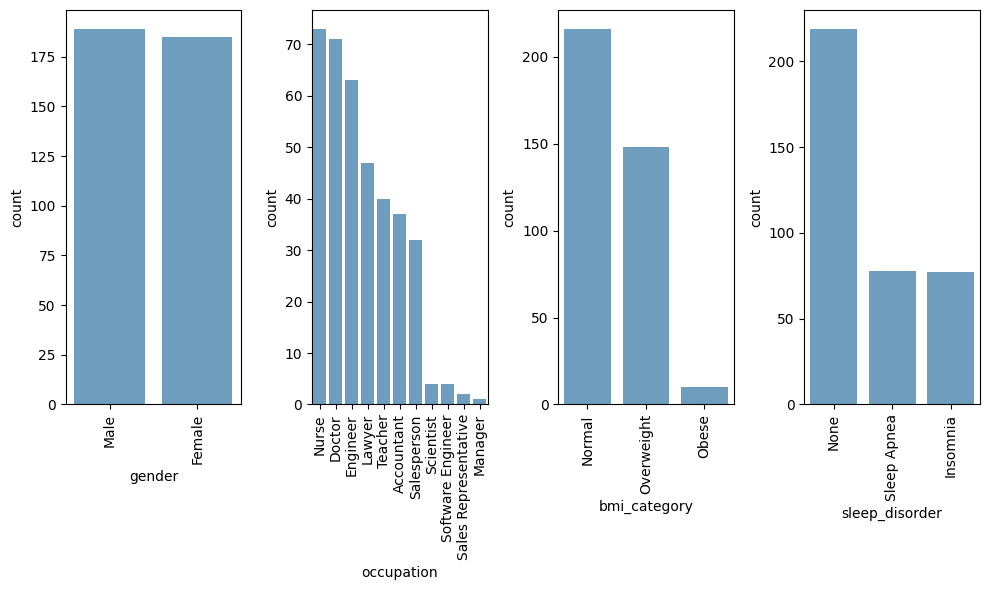

In [126]:
fig, axes = plt.subplots(round(len(categorical) / 3), len(categorical), figsize=(10,6))

for i, ax in enumerate(fig.axes):
    if i < len(categorical):
        order = df[categorical[i]].value_counts().index
        ax.tick_params(axis='x', rotation=90)
        sns.countplot(x=categorical[i], alpha=0.7, data=df[categorical], order=order, ax=ax)

fig.tight_layout()


Now lets plot the categorical variables against `quality_of_sleep`

##### Gender vs Quality of Sleep

([0, 1], [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

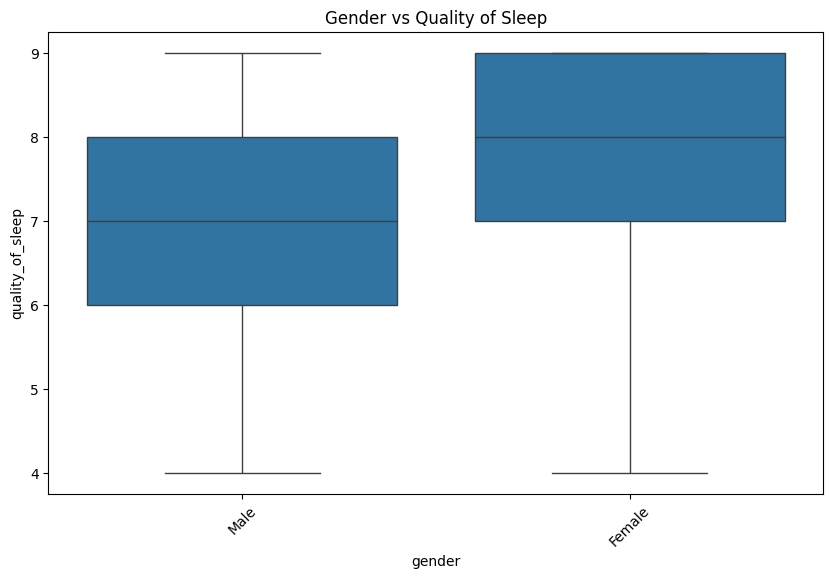

In [128]:
plt.figure(figsize = (10, 6))
order = df['gender'].value_counts().index
ax = sns.boxplot(x='gender', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Gender vs Quality of Sleep')
plt.xticks(rotation=45)

##### Occupation vs Quality of Sleep

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Nurse'),
  Text(1, 0, 'Doctor'),
  Text(2, 0, 'Engineer'),
  Text(3, 0, 'Lawyer'),
  Text(4, 0, 'Teacher'),
  Text(5, 0, 'Accountant'),
  Text(6, 0, 'Salesperson'),
  Text(7, 0, 'Scientist'),
  Text(8, 0, 'Software Engineer'),
  Text(9, 0, 'Sales Representative'),
  Text(10, 0, 'Manager')])

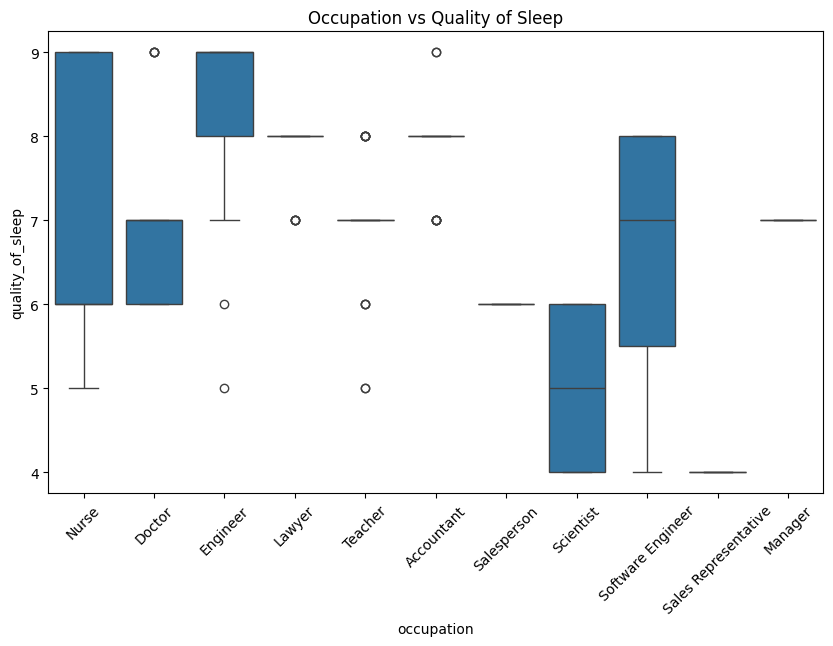

In [127]:
plt.figure(figsize = (10, 6))
order = df['occupation'].value_counts().index
ax = sns.boxplot(x='occupation', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Occupation vs Quality of Sleep')
plt.xticks(rotation=45)

##### BMI vs Quality of Sleep

([0, 1, 2],
 [Text(0, 0, 'Normal'), Text(1, 0, 'Overweight'), Text(2, 0, 'Obese')])

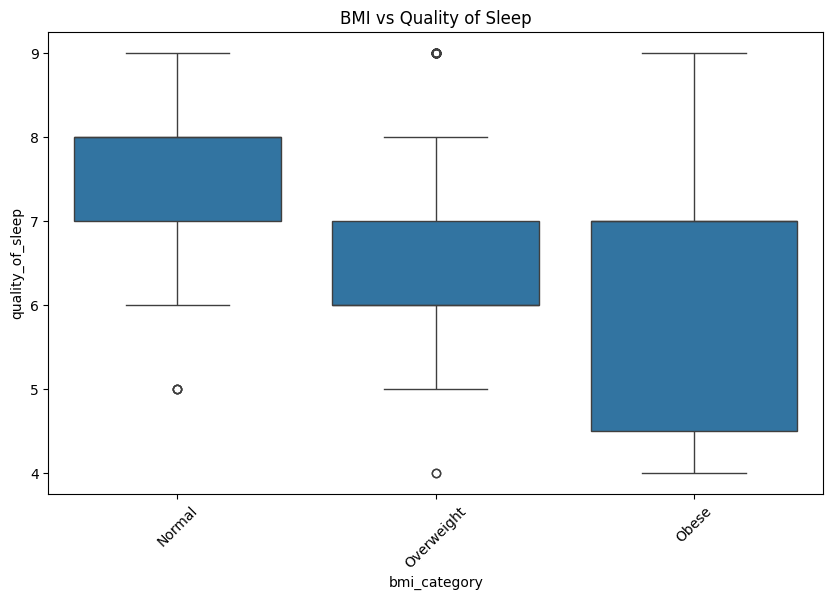

In [129]:
plt.figure(figsize = (10, 6))
order = df['bmi_category'].value_counts().index
ax = sns.boxplot(x='bmi_category', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('BMI vs Quality of Sleep')
plt.xticks(rotation=45)

([0, 1, 2],
 [Text(0, 0, 'None'), Text(1, 0, 'Sleep Apnea'), Text(2, 0, 'Insomnia')])

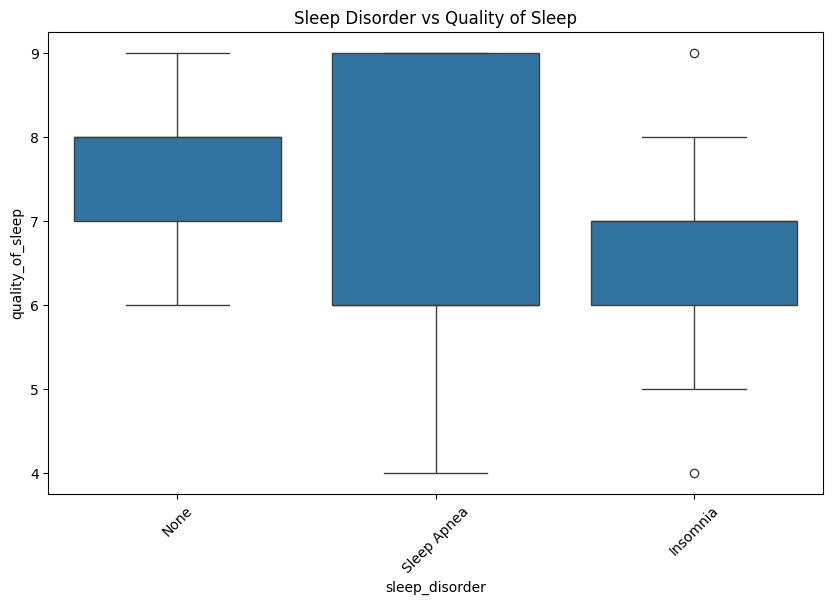

In [130]:
plt.figure(figsize = (10, 6))
order = df['sleep_disorder'].value_counts().index
ax = sns.boxplot(x='sleep_disorder', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Sleep Disorder vs Quality of Sleep')
plt.xticks(rotation=45)

#### Observations from the Exploratory Data Analysis:

### 💤 Findings from Correlation Analysis with Quality of Sleep
🔹 **Positive Correlations**

- *Age*: Individuals in the 29–59 age group show a mild positive correlation with sleep quality, suggesting that middle-aged adults tend to report slightly better sleep quality compared to younger or older groups.

- *Sleep Duration*: A strong positive relationship exists — the longer one sleeps, the better the reported quality of sleep.

- *Physical Activity Level*: Shows a small positive correlation, indicating that regular physical exercise contributes to improved sleep quality.

- *Daily Steps*: Exhibits a very low correlation, suggesting that general movement throughout the day has limited direct impact on sleep quality.

🔻 **Negative Correlations**

- *Blood Pressure (Systolic & Diastolic)*: Both show weak negative correlations with sleep quality. Individuals with higher blood pressure tend to experience poorer sleep quality.

- *Heart Rate*: A negative relationship indicates that higher resting heart rates are often associated with lower sleep quality.

- *Stress Level*: Displays a strong negative correlation, confirming that increased stress levels lead to poorer sleep quality.

### Train Test Split

In [105]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [106]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [107]:
y_full_train = df_full_train.quality_of_sleep
y_train = df_train.quality_of_sleep
y_val = df_val.quality_of_sleep
y_test = df_test.quality_of_sleep

In [108]:
del df_full_train['quality_of_sleep']
del df_train['quality_of_sleep']
del df_val['quality_of_sleep']
del df_test['quality_of_sleep']

In [36]:
df_train.head()

,gender,age,occupation,sleep_duration,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Female,45,Teacher,6.6,45,4,Overweight,65,6000,None,135,90
1,Female,53,Engineer,8.5,30,3,Normal,65,5000,None,125,80
2,Male,44,Salesperson,6.3,45,7,Overweight,72,6000,Insomnia,130,85
3,Male,33,Doctor,6.0,30,8,Normal,72,5000,None,125,80
4,Male,31,Doctor,7.7,75,6,Normal,70,8000,None,120,80


In [37]:
y_train.head()

0    7
1    9
2    6
3    6
4    7
Name: quality_of_sleep, dtype: int64

#### Preprocessing pipeline
Lets build a preprocessing pipeline for data cleaning and scaling

In [38]:
# Pipeline for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Lets combine these into a Column Transformer

In [39]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical),
    ('num', numerical_transformer, numerical)
])

Let's try this for a linear regression model

In [40]:
model = LinearRegression()

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [41]:
pipe.fit(df_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [42]:
print("Model score:", pipe.score(df_val, y_val))

Model score: 0.9320066452084016


In [43]:
print("Model score:", pipe.score(df_test, y_test))

Model score: 0.9647401417017161


### Model Evaluation on Base Model (Without model tuning)
Let's add multiple models into our pipeline on base models which haven't been tuned and evaluate them to get a baseline 

In [117]:
model_eval_base = []

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=1),
    "Random Forest": RandomForestRegressor(random_state=1),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}


for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score_val = pipe.score(df_val, y_val)
    print(f"{name}: R² on validation = {score_val:.3f}")
    
    score_test = pipe.score(df_test, y_test)
    print(f"{name}: R² on test= {score_test:.3f}")
    print()

    model_eval_base.append((name, score_test))

Linear Regression: R² on validation = 0.932
Linear Regression: R² on test= 0.965

Decision Tree: R² on validation = 0.943
Decision Tree: R² on test= 0.965

Random Forest: R² on validation = 0.949
Random Forest: R² on test= 0.979

XGBoost: R² on validation = 0.959
XGBoost: R² on test= 0.980



In [121]:
columns = ['Model', 'TestScore_base']
df_model_eval_base = pd.DataFrame(model_eval_base, columns = columns)
df_model_eval_base

,Model,TestScore_base
0,Linear Regression,0.964740
1,Decision Tree,0.964907
2,Random Forest,0.978933
3,XGBoost,0.979970


### Model Tuning 
Let's tune each of these models

#### Linear Regression with Regularization

If model tuning were like managing a team:

- OLS hires everyone, no matter how redundant.

- Ridge keeps everyone but limits their influence.

- Lasso fires the unhelpful ones.


#### Ridge Regression

**Ridge Regression**: Ridge regression prevents overfitting of data by adding a penalty or a regularization term **$\alpha$**

This “shrinking” is why Ridge is also called *shrinkage regression*.

When features are correlated, Ridge spreads the importance among them instead of giving one huge weight to any single one.

In [48]:
from sklearn.linear_model import Ridge

##### Alpha Tuning for Ridge Regression

In [49]:
scores = []

for a in [0.001, 0.01, 0.1, 0.5, 1.0, 10]:
    model = Ridge(alpha=a)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((a, score))
    print(f"Alpha value of {a}: R² = {score:.3f}")
    print()

Alpha value of 0.001: R² = 0.932

Alpha value of 0.01: R² = 0.932

Alpha value of 0.1: R² = 0.934

Alpha value of 0.5: R² = 0.939

Alpha value of 1.0: R² = 0.940

Alpha value of 10: R² = 0.935



In [50]:
columns = ['Alpha', 'R2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,Alpha,R2
0,0.001,0.932032
1,0.010,0.932259
2,0.100,0.934175
3,0.500,0.938528
4,1.000,0.940463
5,10.000,0.935357


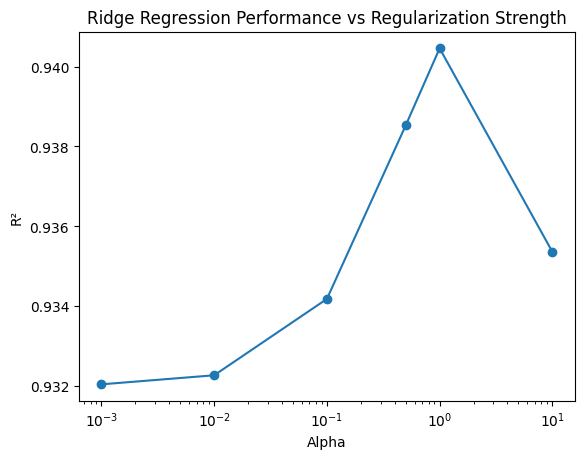

In [51]:
plt.plot(df_scores['Alpha'], df_scores['R2'], marker='o')
plt.xscale('log')  # optional, makes sense if Alpha spans orders of magnitude
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Ridge Regression Performance vs Regularization Strength')
plt.show()

The best value of regularization term for Ridge's **$\alpha$** is **1**

##### Max iterations Tuning for Ridge Regression

In [52]:
scores = []

for i in [1, 10, 100, 1000, 10000]:
    model = Ridge(max_iter=i)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((a, score))
    print(f"Max iteratiion value of {i}: R² = {score:.3f}")
    print()

Max iteratiion value of 1: R² = 0.940

Max iteratiion value of 10: R² = 0.940

Max iteratiion value of 100: R² = 0.940

Max iteratiion value of 1000: R² = 0.940

Max iteratiion value of 10000: R² = 0.940



The output shows that max iteration does not have much impact on the model

##### Final Ridge Regression Model

In [53]:
model = Ridge(alpha=1)

#### Lasso Regression

**Lasso Regression**: Lasso (Least Absolute Shrinkage and Selection Operator) regression is a regularized version of Ordinary Least Squares (OLS) regression.

It adds a penalty term to the loss function that penalizes large coefficient values — encouraging simpler, more generalizable models.

In [54]:
from sklearn.linear_model import Lasso

In [55]:
scores = []

for a in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10]:
    model = Lasso(alpha=a)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((a, score))
    print(f"Alpha value of {a}: R² = {score:.3f}")
    print()

Alpha value of 0.0001: R² = 0.933

Alpha value of 0.001: R² = 0.939

Alpha value of 0.01: R² = 0.937

Alpha value of 0.1: R² = 0.878

Alpha value of 0.5: R² = 0.668

Alpha value of 1.0: R² = 0.058

Alpha value of 10: R² = -0.001



In [56]:
columns = ['Alpha', 'R2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,Alpha,R2
0,0.0001,0.933022
1,0.0010,0.938731
2,0.0100,0.936645
3,0.1000,0.878130
4,0.5000,0.667589
5,1.0000,0.057882
6,10.0000,-0.001155


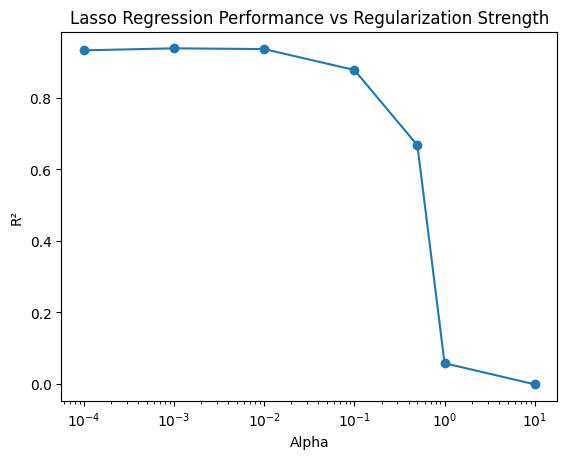

In [57]:
plt.plot(df_scores['Alpha'], df_scores['R2'], marker='o')
plt.xscale('log')  # optional, makes sense if Alpha spans orders of magnitude
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Lasso Regression Performance vs Regularization Strength')
plt.show()

The best value of regularization term for Ridge's **$\alpha$** is **0.001**

##### Max iterations Tuning for Lasso Regression

In [58]:
scores = []

for i in [1, 10, 100, 1000, 10000, 100000]:
    model = Lasso(max_iter=i)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((a, score))
    print(f"Max iteration value of {i}: R² = {score:.3f}")
    print()

Max iteration value of 1: R² = 0.062

Max iteration value of 10: R² = 0.058

Max iteration value of 100: R² = 0.058

Max iteration value of 1000: R² = 0.058

Max iteration value of 10000: R² = 0.058

Max iteration value of 100000: R² = 0.058



/home/codespace/.local/share/virtualenvs/sleep-health-predictor-uEJaSHK5/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.088e-02, tolerance: 3.021e-02
  model = cd_fast.enet_coordinate_descent(


Looks like max iteration does not have much impact on the Lasso model

##### Final Lasso Regression Model

In [59]:
model = Lasso(alpha=0.001)

#### Decision Trees

Let's tune the parameters in the Decision Tree model
- selecting max_depth
- selecting min_samples_leaf

In [60]:
scores = []

for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, 100, None]:
    model = DecisionTreeRegressor(max_depth=d)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((d, score))
    print(f"Max depth value of {d}: R² = {score:.3f}")
    print()

Max depth value of 1: R² = 0.634

Max depth value of 2: R² = 0.848

Max depth value of 3: R² = 0.922

Max depth value of 4: R² = 0.931

Max depth value of 5: R² = 0.943

Max depth value of 6: R² = 0.943

Max depth value of 10: R² = 0.943

Max depth value of 15: R² = 0.943

Max depth value of 20: R² = 0.943

Max depth value of 100: R² = 0.943

Max depth value of None: R² = 0.943



In [61]:
columns = ['max_depth', 'R2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,R2
0,1.0,0.634261
1,2.0,0.847787
2,3.0,0.921617
3,4.0,0.931470
4,5.0,0.943302
5,6.0,0.943302
6,10.0,0.943302
7,15.0,0.943302
8,20.0,0.943302
9,100.0,0.943302


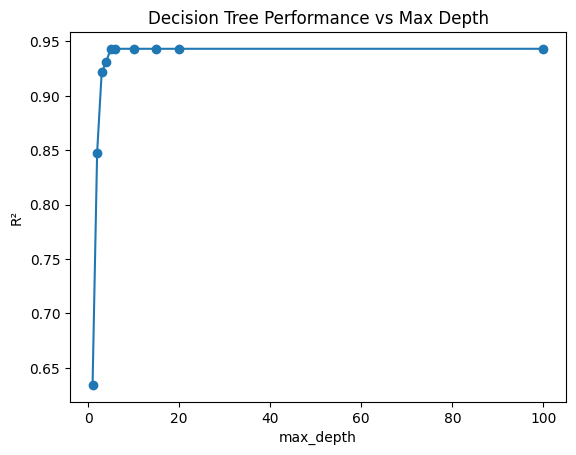

In [62]:
plt.plot(df_scores['max_depth'], df_scores['R2'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('R²')
plt.title('Decision Tree Performance vs Max Depth')
plt.show()

Looks like the **max_depth** of **5** is the best

In [63]:
scores = []

for s in [1, 2, 5, 10, 15, 20, 100, 200, 500, 1000]:
    model = DecisionTreeRegressor(min_samples_leaf=s)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((s, score))
    print(f"min_samples_leaf value of {s}: R² = {score:.3f}")
    print()

min_samples_leaf value of 1: R² = 0.943

min_samples_leaf value of 2: R² = 0.943

min_samples_leaf value of 5: R² = 0.950

min_samples_leaf value of 10: R² = 0.915

min_samples_leaf value of 15: R² = 0.916

min_samples_leaf value of 20: R² = 0.943

min_samples_leaf value of 100: R² = 0.661

min_samples_leaf value of 200: R² = -0.001

min_samples_leaf value of 500: R² = -0.001

min_samples_leaf value of 1000: R² = -0.001



Looks like the **min_samples_leaf** of **5** is the best

##### Final Decision Tree Model

In [64]:
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5)

#### Random Forest Model
Let's tune the parameters in the Decision Tree model
- selecting n_estimators
- selecting max_depth
- selecting min_samples_leaf

##### Tuning n_estimators 

In [65]:
scores = []

for n in range(10, 201, 10):
    model = RandomForestRegressor(n_estimators=n, random_state=1)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((n, score))
    print(f"n_estimators value of {n}: R² = {score:.3f}")
    print()

n_estimators value of 10: R² = 0.948

n_estimators value of 20: R² = 0.951

n_estimators value of 30: R² = 0.948

n_estimators value of 40: R² = 0.948

n_estimators value of 50: R² = 0.952

n_estimators value of 60: R² = 0.949

n_estimators value of 70: R² = 0.948

n_estimators value of 80: R² = 0.950

n_estimators value of 90: R² = 0.948

n_estimators value of 100: R² = 0.949

n_estimators value of 110: R² = 0.952

n_estimators value of 120: R² = 0.953

n_estimators value of 130: R² = 0.952

n_estimators value of 140: R² = 0.953

n_estimators value of 150: R² = 0.954

n_estimators value of 160: R² = 0.954

n_estimators value of 170: R² = 0.954

n_estimators value of 180: R² = 0.953

n_estimators value of 190: R² = 0.953

n_estimators value of 200: R² = 0.953



In [66]:
columns = ['n_estimators', 'R2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,R2
0,10,0.948178
1,20,0.951155
2,30,0.947573
3,40,0.948228
4,50,0.951875
5,60,0.949208
6,70,0.947778
7,80,0.949526
8,90,0.947844
9,100,0.949421


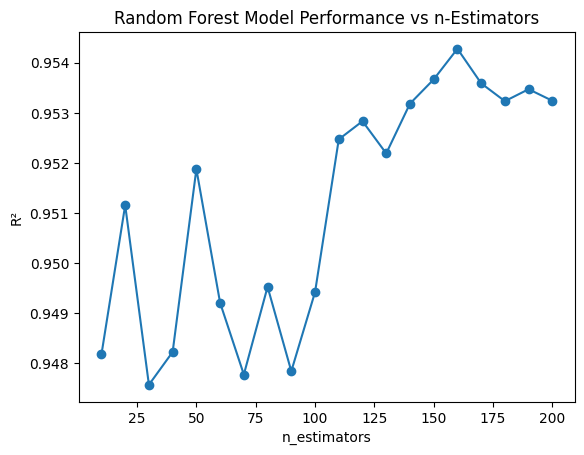

In [67]:
plt.plot(df_scores['n_estimators'], df_scores['R2'], marker='o')
plt.xlabel('n_estimators')
plt.ylabel('R²')
plt.title('Random Forest Model Performance vs n-Estimators')
plt.show()

**n_estimators=160** is the highest

##### Tuning max_depth 

In [68]:
scores = []

for d in [10, 20, 30, 40, 50, 60, 70, 100, 200]:
    for n in range(10, 201, 10):
        model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
        ])
    
        pipe.fit(df_train, y_train)
        score = pipe.score(df_val, y_val)
        scores.append((d, n, score))
        # print(f"max_depth value of {d} and n_estimators value of {n}: R² = {score:.3f}")
        # print()

In [69]:
columns = ['max_depth', 'n_estimators', 'R2']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,max_depth,n_estimators,R2
0,10,10,0.948178
1,10,20,0.951155
2,10,30,0.947573
3,10,40,0.948228
4,10,50,0.951875
...,...,...,...
175,200,160,0.954274
176,200,170,0.953585
177,200,180,0.953229
178,200,190,0.953468


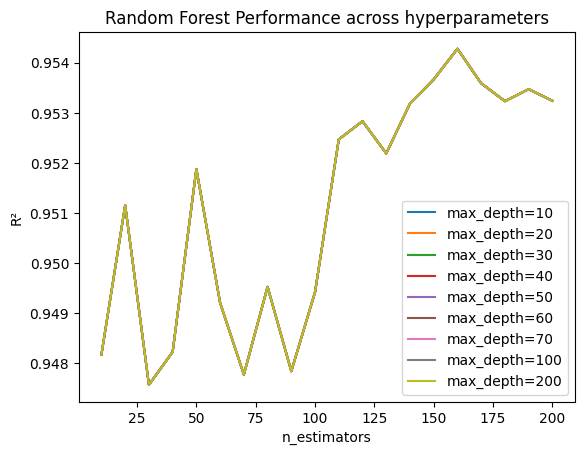

In [70]:
for d in [10, 20, 30, 40, 50, 60, 70, 100, 200]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset['R2'], label='max_depth=%d' %d)
plt.xlabel('n_estimators')
plt.ylabel('R²')
plt.title('Random Forest Performance across hyperparameters')
plt.legend()
plt.show()

Looks like the values are overlapping. So max_depth of 10 is as good as 100 or any other. To show this, let's exaggerate the differences with a plot.

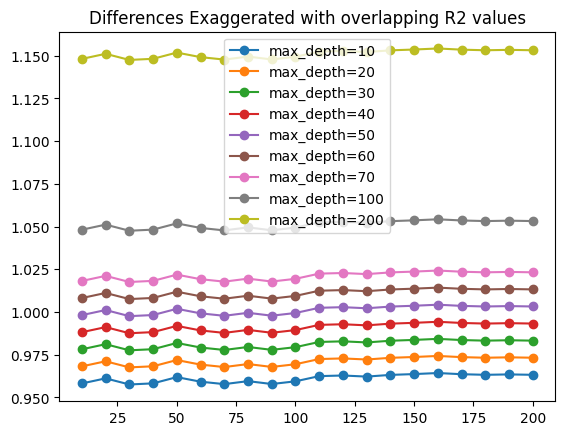

In [71]:
df_scores['R2_adj'] = df_scores['R2'] + df_scores['max_depth'] * 0.001
for d, df_subset in df_scores.groupby('max_depth'):
    plt.plot(df_subset['n_estimators'], df_subset['R2_adj'], marker='o', label=f'max_depth={d}')
plt.title('Differences Exaggerated with overlapping R2 values')
plt.legend()
plt.show()

Let's choose a **max_depth=10** 

##### Tuning min_samples_leaf

In [72]:
scores = []

for l in [1, 3, 5, 10, 50]:
    model = RandomForestRegressor(n_estimators=160, max_depth=10, min_samples_leaf=l, random_state=1)
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((l, score))
    # print(f"max_depth value of {d} and n_estimators value of {n}: R² = {score:.3f}")
    # print()

In [73]:
columns = ['min_samples_leaf', 'R2']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,min_samples_leaf,R2
0,1,0.954274
1,3,0.948868
2,5,0.946269
3,10,0.944880
4,50,0.766060


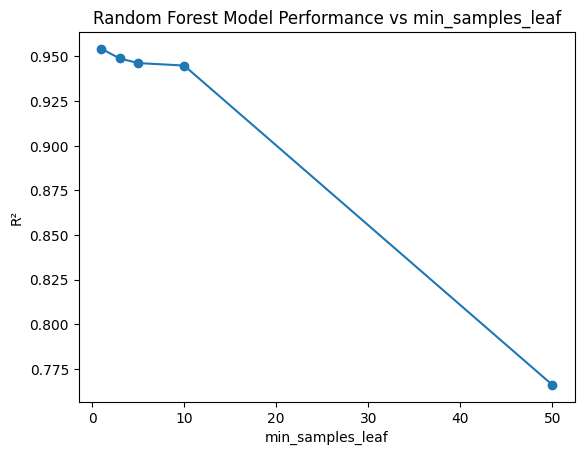

In [74]:
plt.plot(df_scores['min_samples_leaf'], df_scores['R2'], marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('R²')
plt.title('Random Forest Model Performance vs min_samples_leaf')
plt.show()

Let's choose **min_samples_leaf=5** as it is neither too small nor too large and has a steady R²

##### Final Random Forest Model

In [75]:
model = RandomForestRegressor(n_estimators=160, max_depth=10, min_samples_leaf=5, random_state=1)

### Gradient Boosting and XGBoost

#### XGBoost Parameter tuning

##### Tuning learning_rate

In [82]:
scores = []

for lr in [0.01, 0.05, 0.1, 0.3, 1.0, None]:
    model = XGBRegressor(learning_rate=lr, random_state=1, objective='reg:squarederror')
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((lr, score))

In [83]:
columns = ['learning_rate', 'R2']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,learning_rate,R2
0,0.01,0.812910
1,0.05,0.943246
2,0.10,0.953891
3,0.30,0.959091
4,1.00,0.972968
5,NaN,0.959091


Learning rate of **learning_rate=0.3** gives a reasonable R²

##### Tuning max_depth

In [87]:
scores = []

for d in [1, 2, 4, 6, 8, 10]:
    model = XGBRegressor(learning_rate=0.3, max_depth=d, random_state=1, objective='reg:squarederror')
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((d, score))

In [88]:
columns = ['max_depth', 'R2']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,max_depth,R2
0,1,0.946769
1,2,0.970650
2,4,0.965873
3,6,0.959091
4,8,0.957294
5,10,0.957312


**max_depth=2** gives a high R²

##### Tuning min_child_weight
Lets now tune the min_child_weight parameter

In [95]:
scores = []

for l in [0, 1, 3, 5, 10, 15, 20, 25, 30]:
    model = XGBRegressor(learning_rate=0.3, max_depth=2, max_leaves=l, random_state=1, objective='reg:squarederror')
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score = pipe.score(df_val, y_val)
    scores.append((l, score))

In [96]:
columns = ['max_leaves', 'R2']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,max_leaves,R2
0,0,0.970650
1,1,-0.001155
2,3,0.963145
3,5,0.970650
4,10,0.970650
5,15,0.970650
6,20,0.970650
7,25,0.970650
8,30,0.970650


**max_depth=5** gives a high R²

##### Final XGBoost Model

In [97]:
model = XGBRegressor(learning_rate=0.3, max_depth=2, max_leaves=5, random_state=1, objective='reg:squarederror')

Lets put all our trained models and evaluate it

### Model Evaluation on Base Model (After model tuning)

In [116]:
model_eval_tuned = []

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=1),
    "Random Forest": RandomForestRegressor(random_state=1),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}


for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fitting on the full Training dataset
    pipe.fit(df_full_train, y_full_train)

    # Testing it on the Test dataset
    score_test = pipe.score(df_test, y_test)
    print(f"{name}: R² on test= {score_test:.3f}")
    print()

    model_eval_tuned.append((name, score_test))

Linear Regression: R² on test= 0.963

Decision Tree: R² on test= 0.972

Random Forest: R² on test= 0.984

XGBoost: R² on test= 0.974



In [120]:
columns = ['Model', 'TestScore_tuned']
df_model_eval_tuned = pd.DataFrame(model_eval_tuned, columns = columns)
df_model_eval_tuned

,Model,TestScore_tuned
0,Linear Regression,0.962615
1,Decision Tree,0.971926
2,Random Forest,0.983628
3,XGBoost,0.973579


Now lets join the two model evaluation dataframes to see the effect of model tuning

In [122]:
model_eval = pd.merge(df_model_eval_base, df_model_eval_tuned, on='Model')
model_eval

,Model,TestScore_base,TestScore_tuned
0,Linear Regression,0.964740,0.962615
1,Decision Tree,0.964907,0.971926
2,Random Forest,0.978933,0.983628
3,XGBoost,0.979970,0.973579


The results show that **Random Forest** model performs the best. Hence we will choose Random Forest as the final model